# Characterizing time-dependent error channels with Machine learning 
By combining dynamical decoupling, Ramsey measurements and machine learning we aim to seperate and characterize time-dependent error channels. 

In [1]:
from qutip import *
import numpy as np
from IPython.display import Latex

#import numpy.linalg
#from math import *
#from copy import copy
#from keras.models import Sequential
#from tensorflow import keras
import tensorflow as tf
#import gym
#from gym import error, spaces, utils
#from gym.utils import seeding
#from scipy.special import mathieu_a
import matplotlib.pyplot as plt
#from operators import operators as ops
#from gym_simulation import *
import numpy as np
from scipy.optimize import minimize

%%Latex
The goal of this code is to demo a protocol for characterizing time-dependent error channels and distinguishing between them. We start by an example to distinguish between x and z errors on a qubit. For ion traps x corresponds to laser amplitude fluctuations and z to laser frequency drift. We apply dynamical decoupling x,z gates to get the first and second (time-) integrals of the noise signals. 
Here we first demo the protocol up to first order in Dyson series (assuming F and G are small) because it leads to a nice formulae. However, this contains an error which is the sum of 2nd order terms in Dyson series and we will need to rotate the axis of DD gates to compensate for it. In order to do so we utilize ML algorithms (such as RNNs) to rotate the z axis in order to minimize the L1 norm between predicted and actual error signals (more late). This protocol could be adjusted to an experiment depending on whether the change in axis is done online or offline or a combination of them.
Protocol: Consider the Hamiltonian $H = f(t)*\sigma_x + g(t)*\sigma_z$, which includes both $X$ and $Z$ errors. 
We first apply the sequence $(\sigma_x*U_\tau*\sigma_x*U_\tau)*...(\sigma_x*U_\tau*\sigma_x*U_\tau)*(\sigma_x*U_\tau*\sigma_x*U_\tau)$, where $U_\tau$ is the error Hamiltonian for the duration of $\tau$. This will give $e^{-i( I^{}_f(N\tau,t_0) \sigma_x - (I^{}_g(N\tau,t_0)-I^{}_g((N-1)\tau,t_0))\sigma_z )}$, up to 1st order in $\lambda$, $I^{}_{f,g}(N\tau,t_0)$ is the time-integral of $f,g$, i.e., $I^{}_{f}(N\tau, t_0) = \int_{t_0}^{N\tau} f(t) dt$. If $\tau\ll\Lambda_c$, where $\Lambda^x_c$ is an effective cutoff frequency of amplitude drift noise spectrum, then the resulting coherent map will be $e^{-i( I^{}_f(N\tau,0) \sigma_x - \tau g(N\tau))\sigma_z )}$, and if additionally $\tau\Lambda^x_c\ll1$, then the map simplifies to 
\begin{equation}\label{xxDD}
e^{-i I^{}_f(N\tau,t_0) \sigma_x}.     
\end{equation}

Machine Learning: Note that this result is valid only up to 1st order in Dysion series (first order in the max amplitude of channels). In an experiment, $\sigma_x$, $\sigma_z$ gates applied will themselves be rotated due to error channel (if e.g., they are applied with the same laser field) and furthermore the gates are not instantanous. These two will both lead to a second order (in amplidute) deviation from the theoretical result. And this is where we will use a machine learning algorithm (such as LSTM) to find the time-dependent correction to the axis orientation which compensates for both of the second order effects.

In [3]:
#Time-evolution operators 
U_rot = lambda r: (-1.j*(r[0]*sigmax()+r[1]*sigmay()+r[2]*sigmaz())).expm()
#Now rotation with a gauge r[3]
U_rot_gauge = lambda r: (-1.j*(r[0]*sigmax()+r[1]*sigmay()+r[2]*sigmaz())).expm() * np.exp(-1.j*r[3])

U   = lambda F, G: (-1.j*(F*sigmax()+G*sigmaz())).expm()
zUz = lambda F, G: sigmaz()* (-1.j*(F*sigmax()+G*sigmaz())).expm() *sigmaz()
xUx = lambda F, G: sigmax()* (-1.j*(F*sigmax()+G*sigmaz())).expm() *sigmax()

#U   = lambda F, G: (identity(2)-1.j*(F*sigmax()+G*sigmaz()))
#zUz = lambda F, G: sigmaz()* (identity(2)-1.j*(F*sigmax()+G*sigmaz())) *sigmaz()
#xUx = lambda F, G: sigmax()* (identity(2)-1.j*(F*sigmax()+G*sigmaz())) *sigmax()


In [4]:
#Test
#Note that U(F, -G) and U(-F, G) equals to xUx(F,G) and zUz(F,G), respectively.  
F, G = 1.,.5
print( xUx(F,G)*U(F,-G).dag() , zUz(F,G)*U(-F,G).dag() ) 

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[1. 0.]
 [0. 1.]] Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[1. 0.]
 [0. 1.]]


__Examples__

__Example (1): Let's start with a trivial example of error channel given by a constant Hamiltonian $H = f*\sigma_x + g*\sigma_z$. We first apply the sequence $(\sigma_x*U_\tau*\sigma_x*U_\tau)*...(\sigma_x*U_\tau*\sigma_x*U_\tau)*(\sigma_x*U_\tau*\sigma_x*U_\tau)$, where $U_\tau$ is the error Hamiltonian for the duration of $\tau$. This will give $\exp(-i( f N\tau \sigma_x - \tau g\sigma_z))$.
We then apply $(\sigma_z*U_\tau*\sigma_z*U_\tau)*...(\sigma_z*U_\tau*\sigma_z*U_\tau)*(\sigma_z*U_\tau*\sigma_z*U_\tau)$ to obtain $\exp(-i( g N\tau \sigma_z - \tau g\sigma_x))$.__

In [5]:
#Constant error channel H = f*x + g*z
tau = 0.0001
N = 10000
f, g = 2., .5 
F, G = f*tau, g*tau 
zuz, xux, u = zUz(F,G), xUx(F,G), U(F,G)

In [6]:
n = 0
xx_state_list, zz_state_list = [], []
init_state = basis(2,0)
xx_curr_state, zz_curr_state = init_state, init_state
xxDD, zzDD = identity(2), identity(2)
while n<N:
        xx_curr_state, zz_curr_state = (xux*u)*xx_curr_state, (zuz*u)*zz_curr_state
        xx_state_list += [xx_curr_state]
        zz_state_list += [zz_curr_state]
        xxDD, zzDD = (xux*u)*xxDD, (zuz*u)*zzDD 
        n += 1

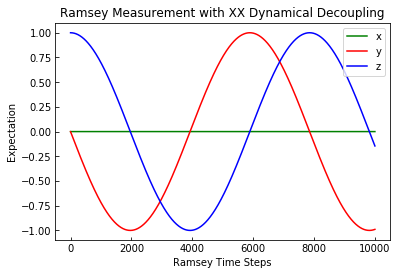

In [40]:
plt.plot([n for n in range(N)], expect(sigmax(), xx_state_list), 'g', label='x' )
plt.plot([n for n in range(N)], expect(sigmay(), xx_state_list), 'r', label='y')
plt.plot([n for n in range(N)], expect(sigmaz(), xx_state_list), 'b', label='z')

plt.xlabel("Ramsey Time Steps")
plt.ylabel("Expectation")
plt.legend()
plt.savefig("XZTime-indep-coherent-channel.jpg")
plt.title("Ramsey Measurement with XX Dynamical Decoupling")
plt.tick_params(axis="y",direction="in")
plt.tick_params(axis="x",direction="in")

plt.show()


__We perform Quantum process tomography at the end of the gate sequence in order to find first and second order integrals of the signal:__

In [8]:
def plt_qpt_gate(U_psi, name, figsize=(8,6)):
    # create a superoperator for the density matrix
    # transformation rho = U_psi * rho_0 * U_psi.dag()
    U_rho = spre(U_psi) * spost(U_psi.dag())
    # operator basis for the process tomography
    op_basis = [[qeye(2), sigmax(), sigmay(), sigmaz()]]
    op_label = [["$i$", "$x$", "$y$", "$z$"]]
    # calculate the chi matrix
    chi = qpt(U_rho, op_basis)
    # visualize the chi matrix
    fig, ax = qpt_plot_combined(chi, op_label, name, figsize=figsize)
    ax.set_title(name)
    
    return chi, fig, ax

def get_chi(U_psi):
    # create a superoperator for the density matrix
    # transformation rho = U_psi * rho_0 * U_psi.dag()
    U_rho = spre(U_psi) * spost(U_psi.dag())
    # operator basis for the process tomography
    op_basis = [[qeye(2), sigmax(), sigmay(), sigmaz()]]
    # calculate the chi matrix
    chi = qpt(U_rho, op_basis)
    
    return chi

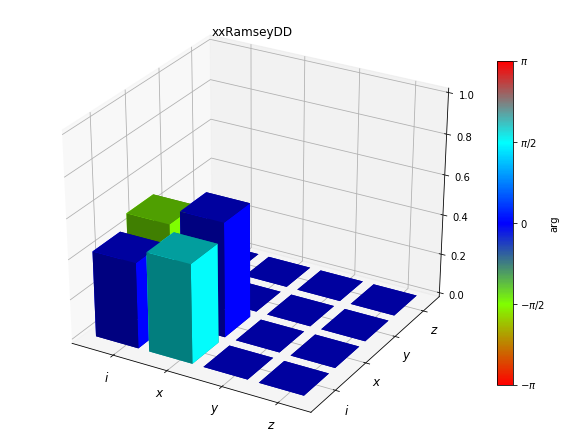

In [9]:
# plot the chi matrix
chi_xxDD = plt_qpt_gate(xxDD, "xxRamseyDD")[0]


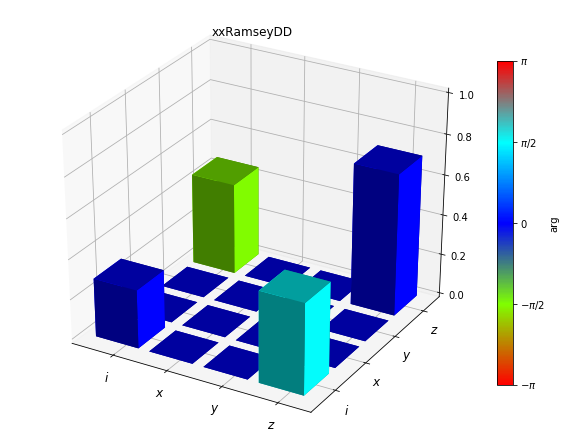

In [10]:
chi_zzDD = plt_qpt_gate(zzDD, "xxRamseyDD")[0]

In [11]:
#In measurements we obtain the process matrix 
chi_xxDD, chi_zzDD
#Now we need to go from process matrices (measurement data) to estimate the coherent error channel parameters. 
#We use gradient descent: 



(array([[ 4.27249985e-01+0.00000000e+00j, -6.77626358e-21-4.94679123e-01j,
          0.00000000e+00+2.47339565e-05j,  0.00000000e+00-0.00000000e+00j],
        [-3.38813179e-21+4.94679123e-01j,  5.72750014e-01+0.00000000e+00j,
         -2.86375011e-05-0.00000000e+00j,  0.00000000e+00-0.00000000e+00j],
        [ 0.00000000e+00-2.47339565e-05j, -2.86375011e-05-0.00000000e+00j,
          1.43187506e-09+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j],
        [ 0.00000000e+00-0.00000000e+00j,  0.00000000e+00-0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j]]),
 array([[ 2.91926588e-01+0.00000000e+00j,  8.91756287e-18+0.00000000e+00j,
         -1.57805626e-16-9.09297427e-05j, -1.11344267e-12-4.54648707e-01j],
        [ 8.91756287e-18+0.00000000e+00j, -3.30872245e-24+0.00000000e+00j,
          0.00000000e+00-2.77932686e-21j,  0.00000000e+00-1.38777878e-17j],
        [-1.57805626e-16+9.09297427e-05j,  0.00000000e+00+2.77932686e-21j,
          2.83229

In [12]:
def chi_err(r,chi_measurement=chi_zzDD):
    U_psi = U_rot(r)
    return np.sum(np.abs(get_chi(U_psi)-chi_measurement)**2)

r0 = np.array([.2, .1, .5])
res = minimize(chi_err, r0, method='nelder-mead',
               options={'xtol': 1e-8, 'disp': True})

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 123
         Function evaluations: 224


In [13]:
res.x

array([3.75236361e-09, 2.00000299e-04, 9.99999974e-01])

In [20]:
#Optimization with gauge altogether (timely)
def run_gauge_optimization():
    phi_list = np.linspace(-np.pi,np.pi,300)[100:200]

    for phi in phi_list:
        def chi_err(r,chi_measurement=chi_zzDD):
            U_psi = U_rot_gauge(r)
            return np.sum(np.abs(get_chi(U_psi)-chi_measurement)**2)

        r0 = np.array([1., .1, .5, phi])
        res = minimize(chi_err, r0, method='nelder-mead',
                       options={'xtol': 1e-8, 'disp': True})
        print(res.x, 'gauge = ', phi)

In [21]:
run_gauge_optimization()

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 186
         Function evaluations: 325
[ 1.84234135e-09  1.99997879e-04  9.99999972e-01 -4.49591686e-01] gauge =  -1.040192885302306
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 186
         Function evaluations: 325
[ 1.84234135e-09  1.99997879e-04  9.99999972e-01 -4.40509026e-01] gauge =  -1.019178887619431
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 186
         Function evaluations: 325
[ 1.84234135e-09  1.99997879e-04  9.99999972e-01 -4.31426365e-01] gauge =  -0.9981648899365565
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 186
         Function evaluations: 325
[ 1.84234135e-09  1.99997879e-04  9.99999972e-01 -4.22343705e-01] gauge =  -0.9771508922536816
Optimization terminated successfully.
         Current functio

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 181
         Function evaluations: 317
[ 3.27314378e-09  2.00002602e-04  9.99999972e-01 -1.31698578e-01] gauge =  -0.3047029664016856
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 181
         Function evaluations: 317
[ 3.27314378e-09  2.00002602e-04  9.99999972e-01 -1.22615917e-01] gauge =  -0.28368896871881066
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 181
         Function evaluations: 317
[ 3.27314378e-09  2.00002602e-04  9.99999972e-01 -1.13533257e-01] gauge =  -0.26267497103593573
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 190
         Function evaluations: 330
[ 4.19006471e-10  2.00000824e-04  9.99999974e-01 -6.32132063e-01] gauge =  -0.2416609733530608
Optimization terminated successfully.
         Current fun

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 194
         Function evaluations: 337
[4.19006471e-10 2.00000824e-04 9.99999974e-01 1.18181212e+00] gauge =  0.45180095018180966
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 181
         Function evaluations: 317
[3.27314378e-09 2.00002602e-04 9.99999972e-01 2.04359862e-01] gauge =  0.4728149478646846
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 181
         Function evaluations: 317
[3.27314378e-09 2.00002602e-04 9.99999972e-01 2.13442522e-01] gauge =  0.4938289455475595
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 181
         Function evaluations: 317
[3.27314378e-09 2.00002602e-04 9.99999972e-01 2.22525183e-01] gauge =  0.5148429432304344
Optimization terminated successfully.
         Current function value: 0.000000